# Model Experiments


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#pip3 install nvidia-ml-py3
import tracemalloc, threading, torch, time, pynvml
from PIL import Image as pil_image
from torchvision.models import densenet121, inception_v3

from fastai.utils.mem import *
from fastai.vision import *
import fastai
print(fastai.__version__)

1.0.43.dev0


In [3]:
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
path = Path('../data/mnist/mnist_png')

In [5]:
np.random.seed(42)

### Custom model

In [6]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)


In [7]:
data = ImageDataBunch.from_folder(path, valid_pct = 0.2, ds_tfms=tfms, size=28)

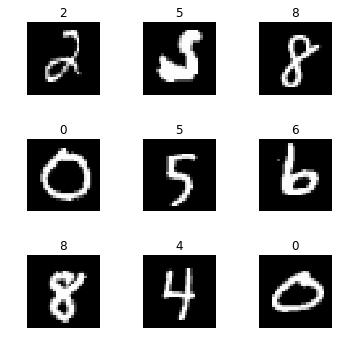

In [8]:
data.show_batch(rows=3, figsize=(5,5))

### Simple linear model

In [41]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

In [42]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): 
        xb = xb[:, 0, :, :]
        xb=xb.view(-1, 28*28)
        return self.lin(xb)

TODO work how to load a greyscale only dataset in fastai. By default 3 channels are created. In above code we use only first channel

In [43]:
model = Mnist_Logistic().to(device)

In [44]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [45]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [46]:
model(x).shape

torch.Size([64, 10])

In [47]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [48]:
loss_func=nn.CrossEntropyLoss()

In [52]:
lr=2e-2

In [53]:
def update(x,y,lr):
    wd = 1e-5
    #get output of model
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): 
        w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [54]:
losses = [update(x,y,lr) for x,y in data.train_dl]

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f68b0a80c50>>
Traceback (most recent call last):
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f68b0a80c50>>
    w.join()
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
AssertionError: can only join

    self._shutdown_workers()
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f68b0a80c50>>
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f68b0a80c50>>
    w.join()
  File "/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/multiprocessing/process.py", line 122, in join
  File 

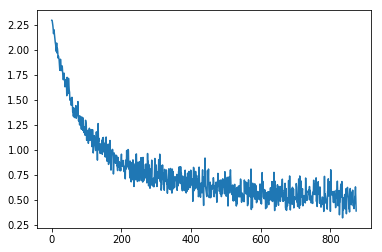

In [55]:
plt.plot(losses)

## 2 Layers

In [56]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        xb = xb[:, 0, :, :]
        xb=xb.view(-1, 28*28)
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [57]:
model = Mnist_NN().to(device)

In [58]:
losses = [update(x,y,lr) for x,y in data.train_dl]

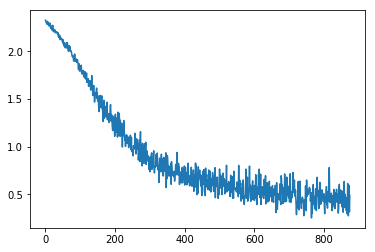

In [59]:
plt.plot(losses)

In [60]:
model = Mnist_NN().to(device)

In [61]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [62]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

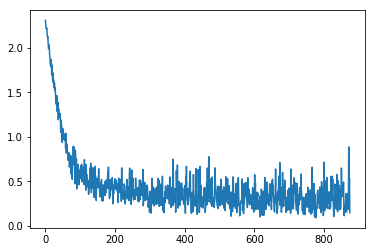

In [63]:
plt.plot(losses)

## 3 Layers

In [64]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 50, bias=True)
        self.lin3 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        xb = xb[:, 0, :, :]
        xb=xb.view(-1, 28*28)
        x = self.lin1(xb)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x

In [65]:
model = Mnist_NN().to(device)

In [66]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

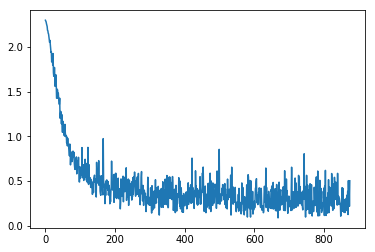

In [67]:
plt.plot(losses)

## Metrics

#### memory profiler

see https://forums.fast.ai/t/gpu-optimizations-central/33944/15

In [42]:
if not torch.cuda.is_available(): raise Exception("pytorch is required")

def preload_pytorch():
    torch.ones((1, 1)).cuda()
    
def gpu_mem_get_used_no_cache():
    torch.cuda.empty_cache()
    return gpu_mem_get().used

def gpu_mem_used_get_fast(gpu_handle):
    info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return int(info.used/2**20)

preload_pytorch()
pynvml.nvmlInit()

class PeakMemMetric(Callback):
    _order=-20 # Needs to run before the recorder
    
    def __init__(self):
        super().__init__()
        self.name = "peak RAM on epoch"

    def peak_monitor_start(self):
        self.peak_monitoring = True

        # start RAM tracing
        tracemalloc.start()

        # this thread samples RAM usage as long as the current epoch of the fit loop is running
        peak_monitor_thread = threading.Thread(target=self.peak_monitor_func)
        peak_monitor_thread.daemon = True
        peak_monitor_thread.start()
        
    def peak_monitor_stop(self):
        tracemalloc.stop()
        self.peak_monitoring = False
        
    def peak_monitor_func(self):
        self.gpu_mem_used_peak = -1

        gpu_id = torch.cuda.current_device()
        gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_id)

        while True:
            gpu_mem_used = gpu_mem_used_get_fast(gpu_handle)
            self.gpu_mem_used_peak = max(gpu_mem_used, self.gpu_mem_used_peak)
            if not self.peak_monitoring: break
            time.sleep(0.001) # 1msec

    #def on_train_begin(self, **kwargs):
    #    self.learn.recorder.add_metric_names(['cpu used',  'peak', 'gpu used',  'peak'])
                    
    def on_epoch_begin(self, **kwargs):
        self.peak_monitor_start()
        self.gpu_before = gpu_mem_get_used_no_cache()

    def on_epoch_end(self, **kwargs):
        cpu_current, cpu_peak =  list(map(lambda x: int(x/2**20), tracemalloc.get_traced_memory()))
        gpu_current = gpu_mem_get_used_no_cache() - self.gpu_before
        gpu_peak    = self.gpu_mem_used_peak      - self.gpu_before
        self.peak_monitor_stop()
        self.metric = torch.tensor(gpu_peak)
        # The numbers are deltas in MBs (beginning of the epoch and the end)
        #self.learn.recorder.add_metrics([cpu_current, cpu_peak, gpu_current, gpu_peak])

In [43]:
class TraceMallocMetric(Callback):
    def __init__(self):
        super().__init__()
        self.name = "peak RAM"

    def on_epoch_begin(self, **kwargs):
        tracemalloc.start()
        
    def on_epoch_end(self, **kwargs):
        current, peak =  tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.metric = torch.tensor(peak)

## Resnet with metrics

models imported by fastai:
    
<pre>
from torchvision.models import ResNet,resnet18,resnet34,resnet50,resnet101,resnet152
from torchvision.models import SqueezeNet,squeezenet1_0,squeezenet1_1
from .darknet import *
from .unet import *
from .wrn import *
</pre>

In [47]:
learn = create_cnn(data, models.resnet18, metrics=[accuracy, TraceMallocMetric()])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


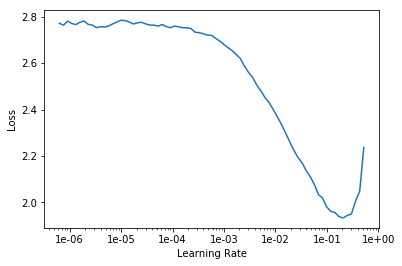

In [45]:
learn.lr_find()
learn.recorder.plot()


In [48]:
learn.fit(2)

#### LearnerCallback

In [9]:
class TraceMallocMultiColMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn):
        super().__init__(learn)
        self.train_max = 0

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['used', 'max_used', 'peak'])
            
    def on_batch_end(self, train, **kwargs):
        # track max memory usage during the train phase
        if train:
            current, peak =  tracemalloc.get_traced_memory()
            self.train_max = max(self.train_max, current)
        
    def on_epoch_begin(self, **kwargs):
        tracemalloc.start()

    def on_epoch_end(self, **kwargs):
        current, peak =  tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.learn.recorder.add_metrics([current, self.train_max, peak])

In [10]:
learn = create_cnn(data, models.resnet18, metrics=[accuracy])
learn.fit_one_cycle(2, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.153082,0.108650,0.968357
2,0.055782,0.038846,0.988286


In [11]:
learn.callbacks.append(TraceMallocMultiColMetric(learn))
learn.fit_one_cycle(2, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,used,max_used,peak
1,0.093590,0.061782,0.982429,481179,2602109,2615911
2,0.056057,0.035865,0.989143,461467,2602109,2594864


### Torchvision models

<pre>
import torchvision.models as models

resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()

use pretrained=True passed into constructor for pre-trained models
</pre>

In [ ]:
#TODO debug why densenet121 throws error when training on MNIST

In [12]:
cats_path = '../data/dogs_cats/data/dogscats/'

In [14]:
cats_data = ImageDataBunch.from_folder(cats_path, valid_pct = 0.2, ds_tfms=tfms, size=224)

In [15]:
learn = create_cnn(cats_data, densenet121, metrics=error_rate)

In [16]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate
1,0.697243,0.699452,0.364664
2,0.679803,0.673166,0.345786


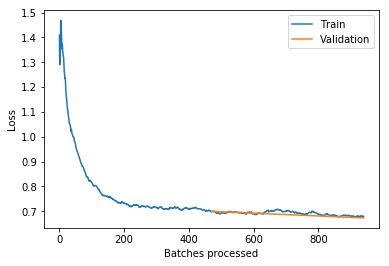

In [19]:
learn.recorder.plot_losses()

### 4 channel images

from https://forums.fast.ai/t/how-to-do-transfer-learning-with-different-inputs/28395

In [ ]:
class ResNet4Channel(nn.Module):
    def __init__(self, encoder_depth, dropout_2d=0.2, pretrained=False):
        super().__init__()
        self.dropout_2d = dropout_2d

        if encoder_depth == 34:
            self.rn = torchvision.models.resnet34(pretrained=pretrained)
            self.bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.rn = torchvision.models.resnet101(pretrained=pretrained)
            self.bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.rn = torchvision.models.resnet152(pretrained=pretrained)
            self.bottom_channel_nr = 2048
        else:
            raise NotImplementedError('only 34, 101, 152 version of Resnet are implemented')
        
        self.input_4_3 = ConvBnRelu(4, 3)  # 
        self.input_adjust = nn.Sequential(self.rn.conv1,
                                          self.rn.bn1,
                                          self.rn.relu)
        self.conv1 = self.rn.layer1
        self.conv2 = self.rn.layer2
        self.conv3 = self.rn.layer3
        self.conv4 = self.rn.layer4 
        self.pool = torch.nn.AvgPool2d(kernel_size=16, stride=1, padding=0)
        self.logit_image = nn.Linear(self.bottom_channel_nr, channels_out)
    
    def forward(self, x):
        batch_size, C, H, W = x.shape
        input_4_3 = self.input_4_3(x)
        input_adjust = self.input_adjust(input_4_3)
        conv1 = self.conv1(input_adjust)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        center = self.conv4(conv3)
        pool = self.pool(center).view(batch_size, self.bottom_channel_nr)
        out = self.logit_image(pool)        
        return out

class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True)
                                  )

    def forward(self, x):
        return self.conv(x)